<a href="https://colab.research.google.com/github/mkro298/imageClassification/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from collections import Counter
import seaborn as sns

import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from skimage import io, transform
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import torchvision.transforms as transforms
scale = 28
distortion_scale = 0.3
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=[-45, 45]),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.Normalize(mean=0.1307, std=0.3081)])

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import Subset

train_dataset = MNIST(root='./data', download=True, train=True, transform=transform)
train_subset_indices = list(range(0, len(train_dataset), 2))
train_subset = Subset(train_dataset, train_subset_indices)

test_dataset = MNIST(root='./data', download=True, train=False, transform=transform)
test_subset_indices = list(range(0, len(test_dataset), 2))
test_subset = Subset(test_dataset, test_subset_indices)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print('=============')
print(len(train_subset))
print(len(test_subset))
print('=============')
transforms_list = []
for i in range(len(train_dataset.transform.transforms)):
  transforms_list.append(str(train_dataset.transform.transforms[i]))
print(transforms_list)
print(len(transforms_list))

60000
10000
30000
5000
['Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)', 'ToTensor()', 'RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)', 'RandomPerspective(p=0.5)', 'Normalize(mean=0.1307, std=0.3081)']
5


In [ ]:
batch = 64

from torch.utils.data import DataLoader
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)

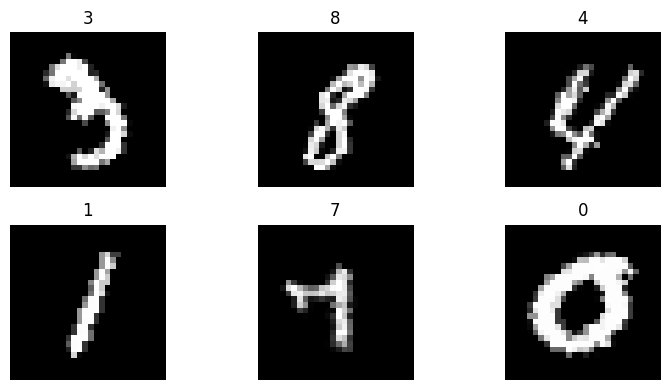

In [ ]:
torch.manual_seed(42)
sample_idxs = [10, 300, 700, 2708, 5035, 8000] 



plt.figure(figsize=(8,4))

for n, sample_idx in enumerate(sample_idxs):
    data, label = train_dataset[sample_idx]
    data = data.permute(1,2,0).detach().cpu().numpy()
    ax = plt.subplot(2, 3, n + 1)

    ax.imshow(data, cmap='gray')

    # chart formatting
    ax.set_title(label)
    ax.grid(False)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  output_dim = math.floor((input_dim + 2 * padding - 1 * (kernel_size - 1) - 1) / stride) + 1

  return output_dim

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()


        # Convolution Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1)
        # input dim = 1 channels, with image size 28 x 28
        # output dim = 5 channels, with image size 27 x 27
        self.mp1 = nn.MaxPool2d(kernel_size=2) # default stride is the same as the kernel size
        # input dim = 5 channels, with image size 27 x 27
        # output dim = 5 channels, with image size 13 x 13
        self.relu = nn.ReLU()

        # Convolution Block 2 
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        # input dim = 5 channels, with image size 13 x 13
        # output dim = 10 channels, with image size 12 x 12

        # 2. Flatten the 2D image into a 1D tensor
        self.flatten = nn.Flatten()

        # 3. Initialize 1-3 fully-connected layers
        self.fc1 = nn.Linear(in_features=250, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)


    def forward(self, x):

        outputs = self.conv1(x)
        outputs = self.mp1(outputs)
        outputs = self.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.mp2(outputs)
        outputs = self.relu(outputs)

        outputs = self.flatten(outputs)

        outputs = self.relu(self.fc1(outputs))
        outputs = self.relu(self.fc2(outputs))

        return outputs

In [ ]:
CNN()

CNN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=250, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
)

In [ ]:
%%time
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(cnn.parameters(), lr=1e-4) 
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) 
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = cnn(inputs)
      predictions = torch.argmax(outputs, dim=1)

      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      correct += (predictions == labels).sum().detach().cpu().numpy()
      total += len(labels)

  accuracy = (correct/total) * 100
  acc_LIST_CNN.append(accuracy)

  loss_LIST_CNN.append(running_loss / len(train_loader))


  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 2.3003383394497545, Accuracy = 35.45333333333333
The loss for Epoch 1 is: 1.1982160712610175, Accuracy = 63.17333333333334
The loss for Epoch 2 is: 0.9717692981905012, Accuracy = 69.64
The loss for Epoch 3 is: 0.8411810989064703, Accuracy = 73.80333333333333
The loss for Epoch 4 is: 0.7349847025835692, Accuracy = 77.11333333333333
The loss for Epoch 5 is: 0.6519199607214694, Accuracy = 79.96666666666667
The loss for Epoch 6 is: 0.5974982574677417, Accuracy = 81.62666666666667
The loss for Epoch 7 is: 0.5388210373900847, Accuracy = 83.34
The loss for Epoch 8 is: 0.49957758575868505, Accuracy = 84.70333333333333


In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) 
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().detach().cpu().numpy()
        total += len(labels)

test_acc_CNN = 100 * correct / total

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 86.68
